In [1]:
import tensorflow as tf
tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.preprocessing.image import ImageDataGenerator
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator,random_rotation,save_img,load_img,img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

In [4]:
#train_files = []
#mask_files = glob('/home/gxt/study/BrainSegmentation/BrainMRI/dataset/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

#for i in mask_files:
    #train_files.append(i.replace('_mask',''))

#print(train_files[:10])
#print(mask_files[:10])
#print(len(train_files))
#print(len(mask_files))
train_files = []
mask_files = []
train = glob('./Doctor-label/Imgs/*')
mask = glob('./Doctor-label/GT/*')
for i in train:
    train_files.append(i)
for i in mask:
    mask_files.append(i)
print(len(train_files))
print(len(mask_files))

98
98


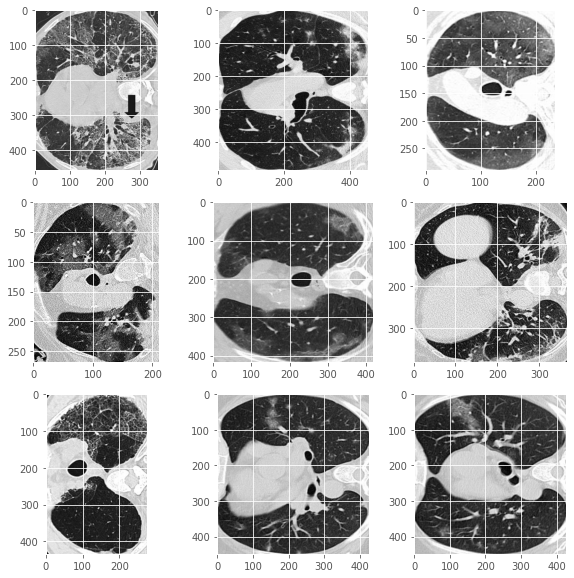

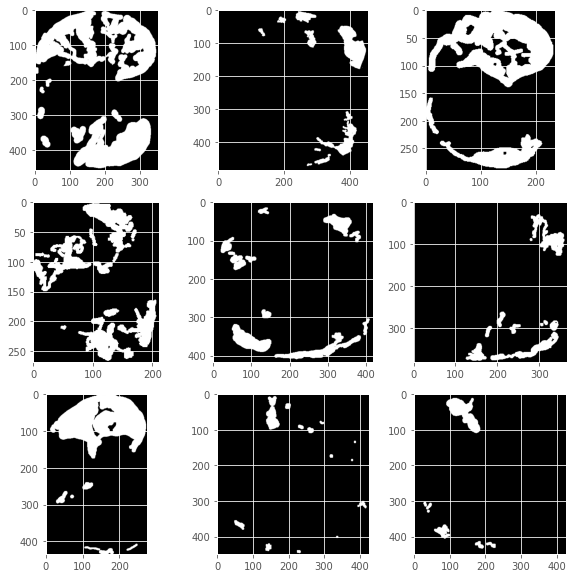

In [5]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    #msk_path=mask_files[i]
    img=cv2.imread(img_path)
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #msk=cv2.imread(msk_path)
    plt.imshow(img)
    #plt.imshow(msk,alpha=0.4)
    #plt.imshow(msk)
plt.show()
row,col=3,3
fig1=plt.figure(figsize=(10,10))
for i in range(1,row*col+1):
    fig1.add_subplot(row,col,i)
    #img_path=train_files[i]
    msk_path=mask_files[i]
    #img=cv2.imread(img_path)
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    #plt.imshow(img)
    #plt.imshow(msk,alpha=0.4)
    plt.imshow(msk)
plt.show()

In [6]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(70, 2)
(18, 2)
(10, 2)


In [7]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict) 
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        shuffle = False,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        shuffle = False,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [8]:
smooth=100
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [9]:
def conv_block(inputs, 
            neuron_num, 
            kernel_size,  
            use_bias, 
            padding= 'same',
            strides= (1, 1),
            with_conv_short_cut = False):
        conv1 = Conv2D(
            neuron_num,
            kernel_size = kernel_size,
            activation= 'relu',
            strides= strides,
            use_bias= use_bias,
            padding= padding
        )(inputs)
        conv1 = BatchNormalization(axis = 1)(conv1)

        conv2 = Conv2D(
            neuron_num,
            kernel_size= kernel_size,
            activation= 'relu',
            use_bias= use_bias,
            padding= padding)(conv1)
        conv2 = BatchNormalization(axis = 1)(conv2)

        if with_conv_short_cut:
            inputs = Conv2D(
                neuron_num, 
                kernel_size= kernel_size,
                strides= strides,
                use_bias= use_bias,
                padding= padding
                )(inputs)
            return add([inputs, conv2])

        else:
            return add([inputs, conv2])


def unet_res(input_size = (224,224,3)):
    inputs = Input(shape= input_size)
    
    #x = ZeroPadding2D((3, 3))(inputs)
    #x = Input(shape= input_size)
    #print("x=",x.shape)
    # Define the converlutional block 1
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)
    
    #Define upsample
    up6 = Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(bn5)
    #up6 = Conv2D(256, 2, activation='relu', padding = 'same')(UpSampling2D(size=(2,2))(x5))
    merge6 = concatenate([bn4,up6],axis = 3)
    conv6 = Conv2D(512,3,activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512,3,activation='relu', padding='same')(conv6)
    
    up7 = Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(conv6)
    #up7 = Conv2D(128, 2, activation='relu', padding = 'same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([bn3,up7],axis = 3)
    conv7 = Conv2D(256,3,activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256,3,activation='relu', padding='same')(conv7)
    
    up8 = Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(conv7)
    #up8 = Conv2D(64, 2, activation='relu', padding = 'same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([bn2,up8],axis = 3)
    conv8 = Conv2D(128,3,activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128,3,activation='relu', padding='same')(conv8)
    
    up9 =  Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(conv8)
    merge9 = concatenate([bn1,up9],axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    return model

In [10]:
model = unet_res()
model.summary()
#plot_model(model, to_file='./model2.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [11]:
#Set Parameters
im_width = 224
im_height = 224

In [12]:
EPOCHS = 50
BATCH_SIZE = 1
learning_rate = 1e-4

In [13]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                save_to_dir='./Aug/Imgs',
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                save_to_dir='./Aug/Imgs',
                                target_size=(im_height, im_width))
    
model = unet_res(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay= decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef,"AUC"])
#model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [ModelCheckpoint('unety_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]
model_checkpoint = ModelCheckpoint('unety_membrane.hdf5', verbose=1, save_best_only=True)
#history = model.fit_generator(train_gen,
#                    steps_per_epoch=100, 
#                    epochs=EPOCHS, 
#                    callbacks= [model_checkpoint],
#                    validation_data = test_gener,
#                    validation_steps=100)
history = model.fit(train_gen,
                    steps_per_epoch=70, 
                    epochs=EPOCHS, 
                    callbacks= [model_checkpoint],
                    validation_data = test_gener,
                    validation_steps=70)

Found 70 validated image filenames.
Found 70 validated image filenames.
Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: -0.3233 - binary_accuracy: 0.8129 - iou: 0.2154 - dice_coef: 0.3233 - auc: 0.7755Found 18 validated image filenames.
Found 18 validated image filenames.
70/70 [==============================] - 17s 131ms/step - loss: -0.3246 - binary_accuracy: 0.8130 - iou: 0.2164 - dice_coef: 0.3246 - auc: 0.7759 - val_loss: -0.2716 - val_binary_accuracy: 0.5243 - val_iou: 0.1689 - val_dice_coef: 0.2716 - val_auc: 0.5589

Epoch 00001: val_loss improved from inf to -0.27163, saving model to unety_membrane.hdf5
Epoch 2/50
70/70 [==============================] - 8s 113ms/step - loss: -0.5911 - binary_accuracy: 0.8846 - iou: 0.4355 - dice_coef: 0.5911 - auc: 0.8012 - val_loss: -0.3038 - val_binary_accuracy: 0.4879 - val_iou: 0.1982 - val_dice_coef: 0.3038 - val_auc: 0.6480

Epoch 00002: val_loss improved from -0.27163 to -0.30383, saving model to unety_membrane.hdf5


70/70 [==============================] - 15s 212ms/step - loss: -0.7804 - binary_accuracy: 0.9410 - iou: 0.6500 - dice_coef: 0.7804 - auc: 0.8928 - val_loss: -0.6904 - val_binary_accuracy: 0.8967 - val_iou: 0.5610 - val_dice_coef: 0.6904 - val_auc: 0.8620

Epoch 00047: val_loss did not improve from -0.72878
Epoch 48/50
70/70 [==============================] - 15s 216ms/step - loss: -0.7910 - binary_accuracy: 0.9424 - iou: 0.6642 - dice_coef: 0.7910 - auc: 0.9044 - val_loss: -0.6846 - val_binary_accuracy: 0.8905 - val_iou: 0.5564 - val_dice_coef: 0.6846 - val_auc: 0.8980

Epoch 00048: val_loss did not improve from -0.72878
Epoch 49/50
70/70 [==============================] - 15s 222ms/step - loss: -0.7885 - binary_accuracy: 0.9411 - iou: 0.6609 - dice_coef: 0.7885 - auc: 0.9089 - val_loss: -0.7251 - val_binary_accuracy: 0.9222 - val_iou: 0.5955 - val_dice_coef: 0.7251 - val_auc: 0.8671

Epoch 00049: val_loss did not improve from -0.72878
Epoch 50/50
70/70 [==============================

In [14]:
model.save('./model/unety_Lung_CT_seg.h5')

In [15]:
model = load_model('./model/unety_Lung_CT_seg.h5',custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
model = load_model('unet_Lung_CT_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [16]:
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef,'AUC'])
test_gen = train_generator(df_test, BATCH_SIZE,
                           dict(),
                                target_size=(im_height, im_width))
print(len(df_test))
results = model.evaluate(x=test_gen,batch_size=BATCH_SIZE, steps=len(df_test)/BATCH_SIZE)
#results = model.predict(x=test_gen,batch_size=BATCH_SIZE, steps=len(df_test)/BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])
print("Test_auc:",results[3]*100,"%")

10
Found 10 validated image filenames.
Found 10 validated image filenames.
10/10 [==============================] - 2s 93ms/step - loss: -0.6849 - binary_accuracy: 0.9247 - iou: 0.5510 - dice_coef: 0.6849 - auc: 0.8766
Test lost:  -0.6469607353210449
Test IOU:  0.9021464586257935
Test Dice Coefficent:  0.5229120254516602
Test_auc: 64.69607353210449 %


In [17]:
train_auc = history.history['auc'][49]
test_auc = results[3]
train_mAP = train_auc/2
test_mAP = test_auc/2
print("train_mAP:",train_mAP*100,"%")
print("test_mAP:",test_mAP*100,"%")

train_mAP: 45.026302337646484 %
test_mAP: 32.348036766052246 %


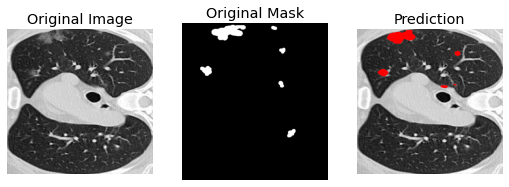

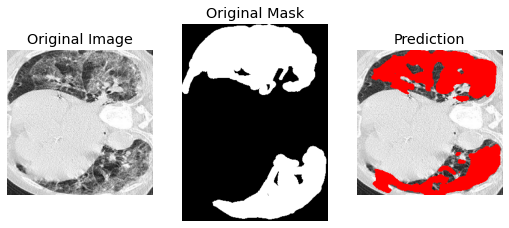

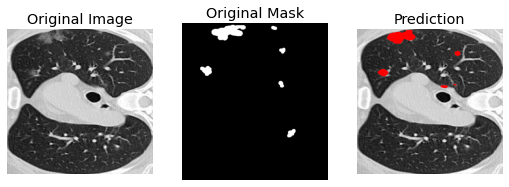

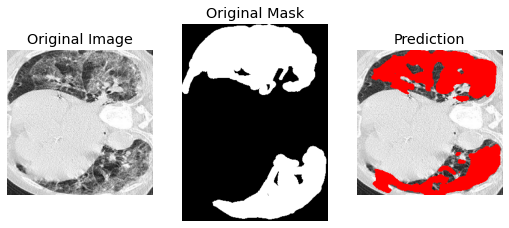

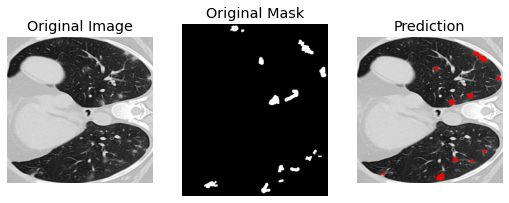

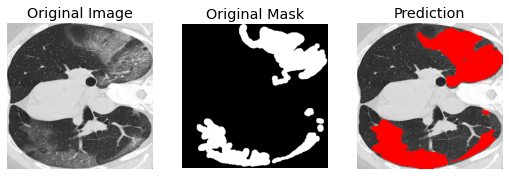

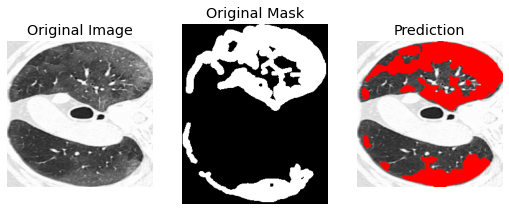

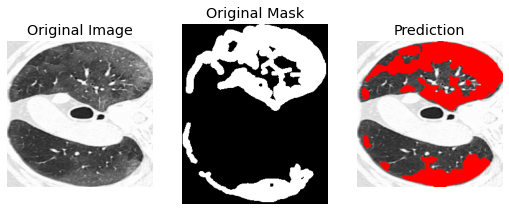

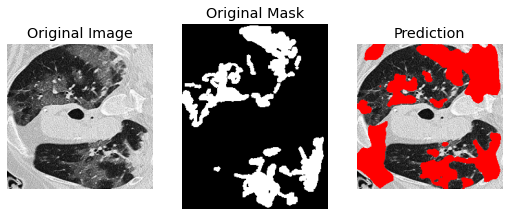

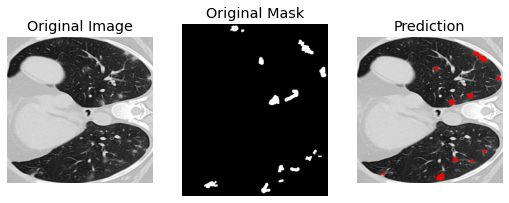

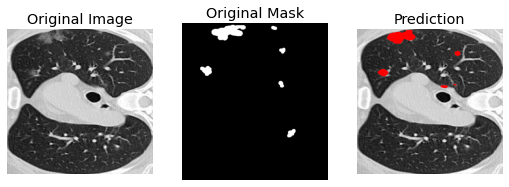

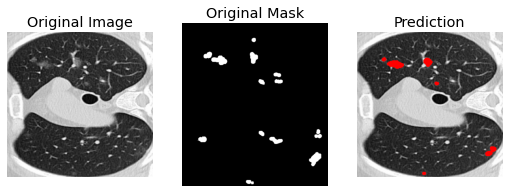

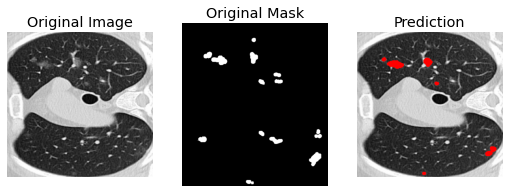

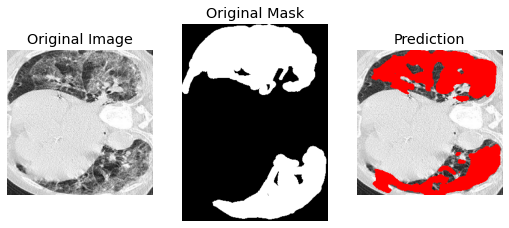

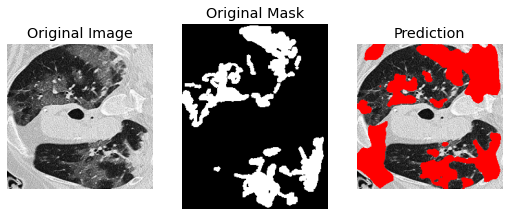

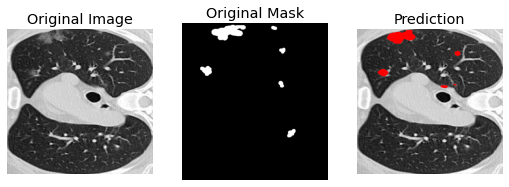

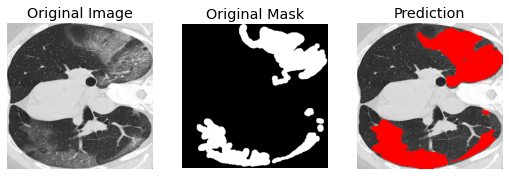

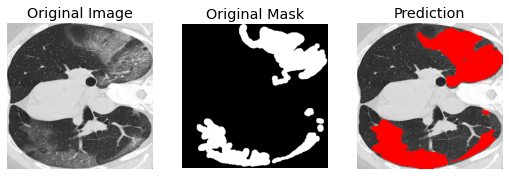

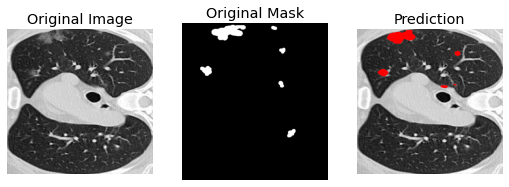

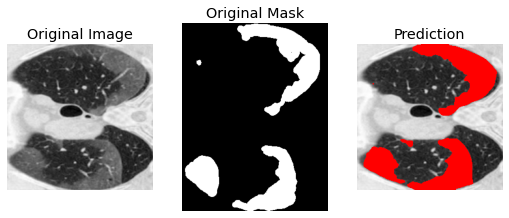

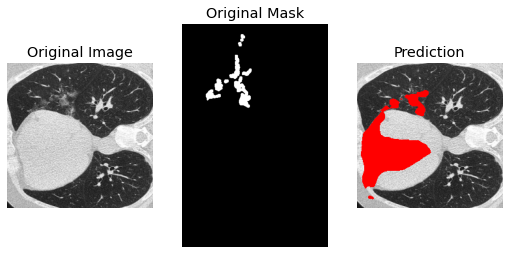

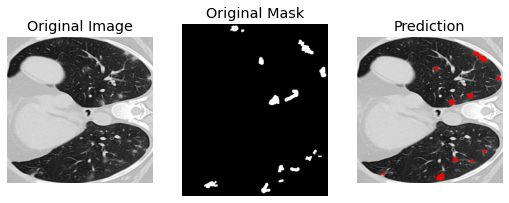

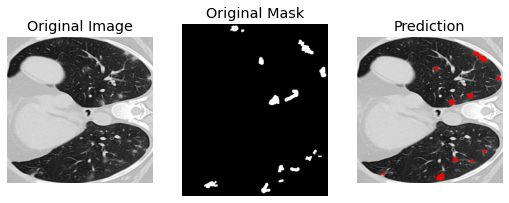

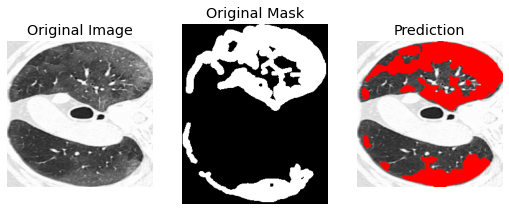

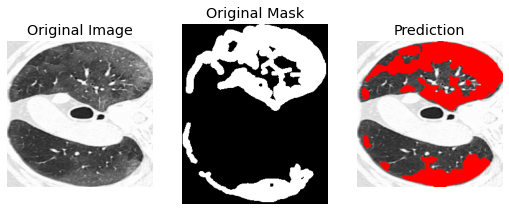

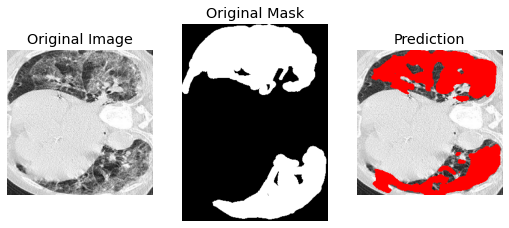

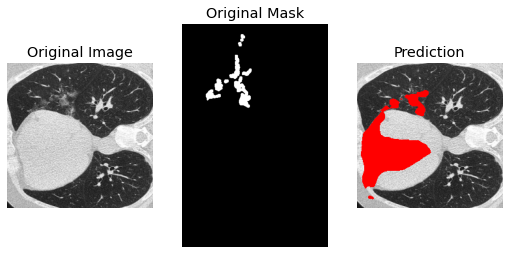

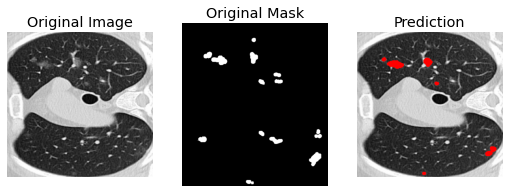

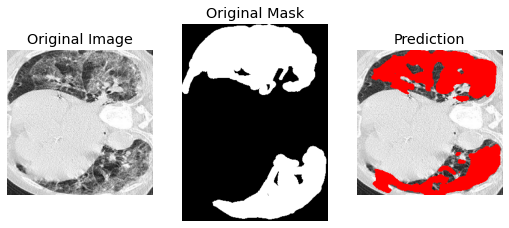

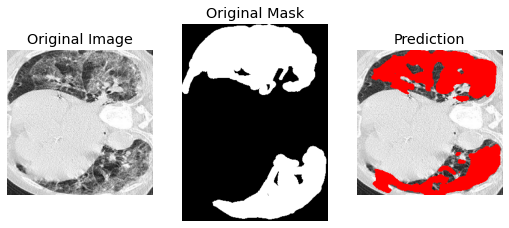

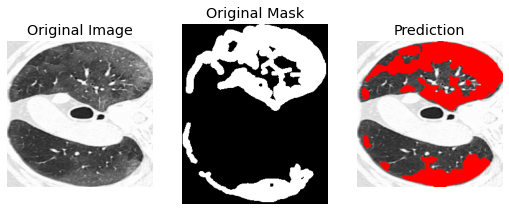

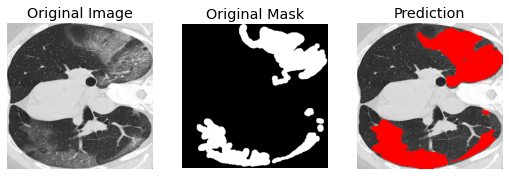

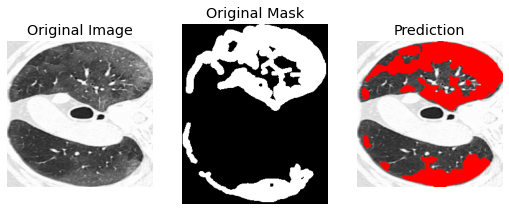

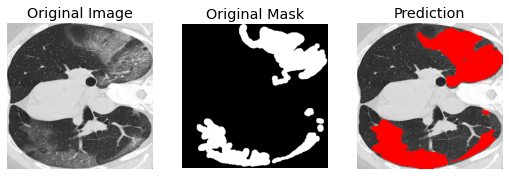

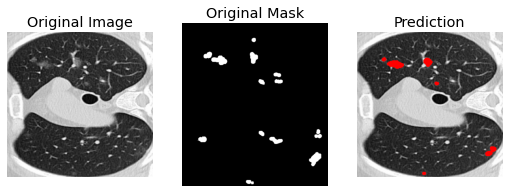

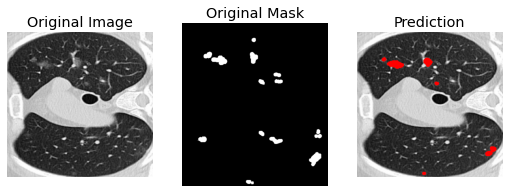

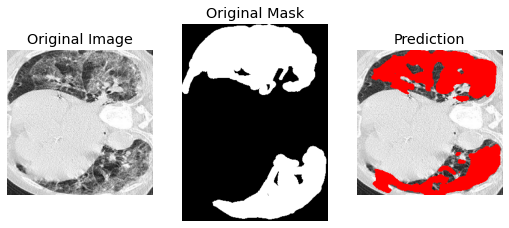

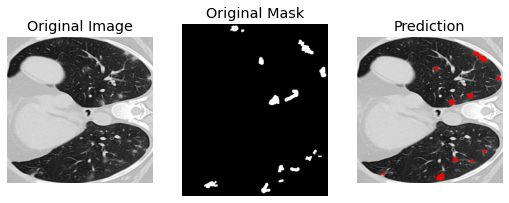

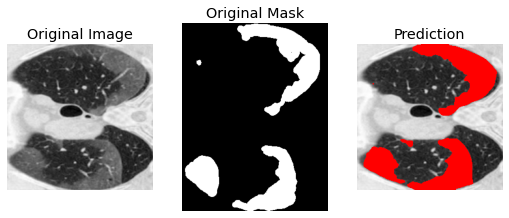

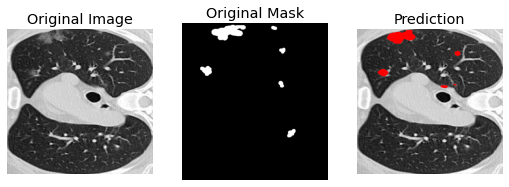

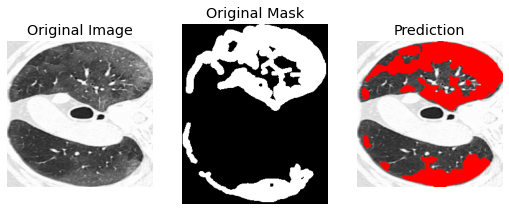

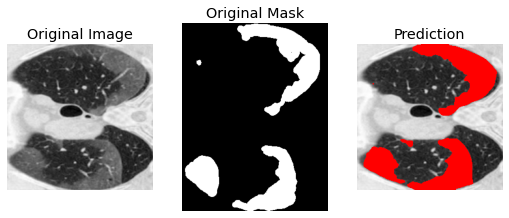

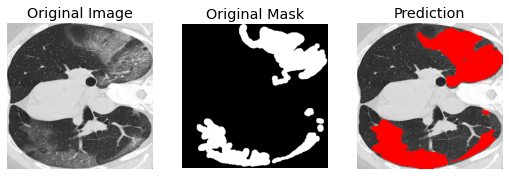

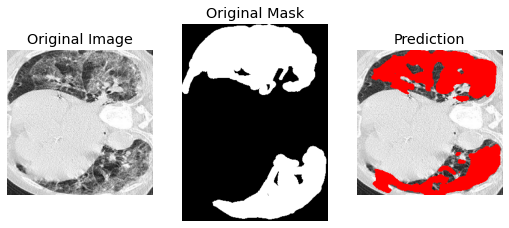

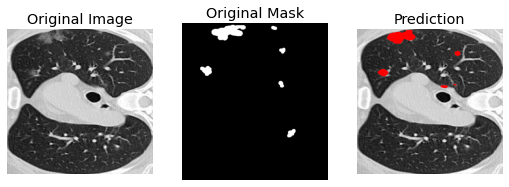

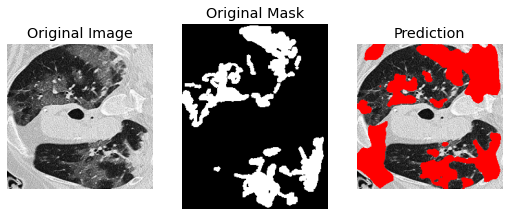

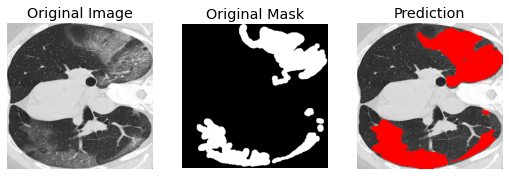

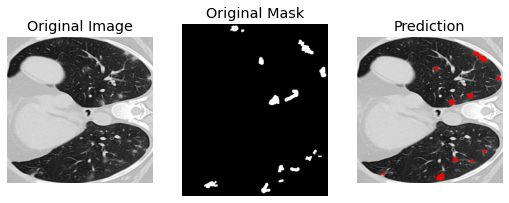

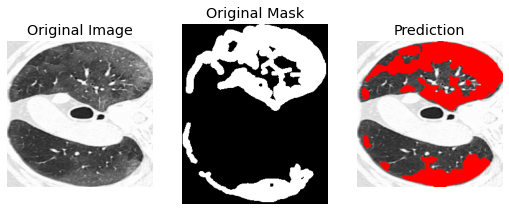

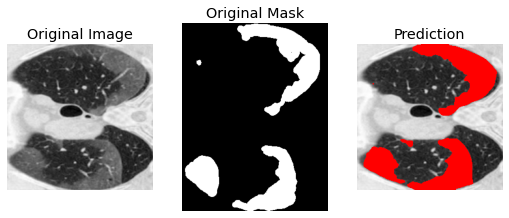

In [18]:
for i in range(50):
    path = "./pred/Unet/"
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
         #print(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
         #print(path+df_test['filename'].iloc[index])
    #cv2.imwrite(path+i+".png", np.squeeze(img))
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')
    img=np.squeeze(img)
    img[np.squeeze(pred) > .6]=(1,0,0)
    plt.subplot(1,4,3)
    #plt.imshow(np.squeeze(pred) > .6)
    #plt.title('Prediction')
             #plt.subplot(1,4,4)
             #plt.title('cover')
             #squeeze  =np.squeeze(pred) > .6
             #dst = cv2.addWeighted(img1,1,img2,0.7,0) 
    #plt.show()
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Prediction')
    plt.savefig(path+str(i)+".png")
    plt.show()

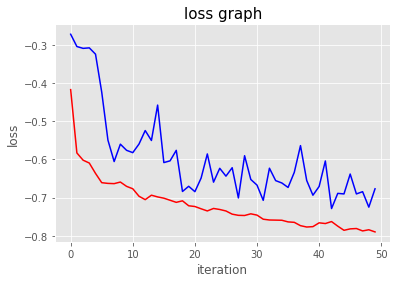

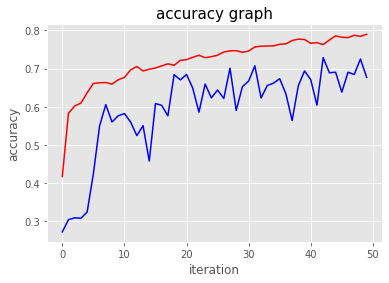

In [19]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()